# <div align='center'> Handwritten Digit Clasiffication Using PyTorch</div>

In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

### Downloading and Normalizing the Data

In [2]:
# Transformations to be applied to the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the Training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the Test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

**NOTE**: Here we shall be loading the data as a batch and each batch will be of the form [64, 1, 28, 28] ie 64 samples, 1 colour channel 28*28 pixles

### Model

In [8]:
Input_Nodes = 784
Hidden_Node = 100
Output_Node = 10
epochs = 10
lr = 0.38

Model1 = nn.Sequential(nn.Linear(Input_Nodes,Hidden_Node),
                       nn.Sigmoid(),
                       nn.Linear(Hidden_Node,Output_Node),
                       nn.LogSoftmax(dim=1)
                      )
print(Model1)

Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=100, out_features=10, bias=True)
  (3): LogSoftmax()
)


**NOTE**: Here I shall be using a different error function instead of *MSE* I used in my other implimentation.

### Cost Function

In [4]:
#ie the Error Function
CostFn = nn.NLLLoss()

### Training and Validating Phase

Epoch: 1/10..  Training Loss: 0.434..  Test Loss: 0.256..  Test Accuracy: 92.605
Epoch: 2/10..  Training Loss: 0.205..  Test Loss: 0.196..  Test Accuracy: 94.228
Epoch: 3/10..  Training Loss: 0.155..  Test Loss: 0.140..  Test Accuracy: 95.890
Epoch: 4/10..  Training Loss: 0.125..  Test Loss: 0.143..  Test Accuracy: 95.770
Epoch: 5/10..  Training Loss: 0.106..  Test Loss: 0.137..  Test Accuracy: 96.158
Epoch: 6/10..  Training Loss: 0.093..  Test Loss: 0.133..  Test Accuracy: 96.168
Epoch: 7/10..  Training Loss: 0.082..  Test Loss: 0.113..  Test Accuracy: 96.576
Epoch: 8/10..  Training Loss: 0.073..  Test Loss: 0.091..  Test Accuracy: 97.293
Epoch: 9/10..  Training Loss: 0.066..  Test Loss: 0.092..  Test Accuracy: 97.174
Epoch: 10/10..  Training Loss: 0.059..  Test Loss: 0.092..  Test Accuracy: 97.034


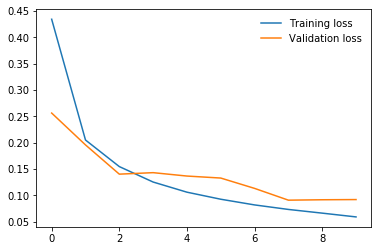

In [9]:
def Train(trainloader,testloader,Model,lr,epoch):
    
    train_losses, test_losses = [], []
    
    optimizer = optim.SGD(Model.parameters(), lr=lr)
    
    for e in range(epoch):
        LossComputed = 0
        for data, lables in trainloader:
            data = data.view(data.shape[0],-1) #64*784
        
            optimizer.zero_grad()
            Model_out = Model(data)
            Loss = CostFn(Model_out,lables)
        
            #BackPropagation
            Loss.backward()
            #Updation_Step
            optimizer.step()
        
            LossComputed += Loss
        else:
            test_loss = 0
            accuracy = 0
        
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                Model.eval() #Turning off the DropOut layer while Testing
                for images, labels in testloader:
                    images = images.view(images.shape[0],-1)
                    log_ps = Model(images)
                    test_loss += CostFn(log_ps, labels)
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))     
            
            Model.train() #Turning on the DropOut layer
            
            train_losses.append(LossComputed/len(trainloader))
            test_losses.append(test_loss/len(testloader))

            print("Epoch: {}/{}.. ".format(e+1, epoch),
              "Training Loss: {:.3f}.. ".format(LossComputed/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(100*(accuracy/len(testloader))))
            
    # Ploting Training vs Validation Error
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)
 

Train(trainloader,testloader,Model1,lr,epochs)

In [6]:
''' 
Function for viewing an image and it's predicted classes.
'''
def view_classify(img, ps, version="MNIST"):
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

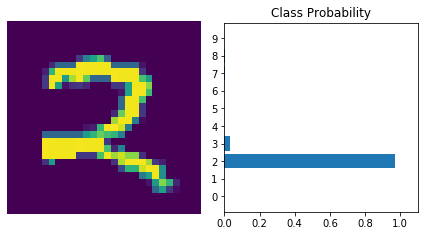

In [15]:
images, labels = next(iter(trainloader))
img = images[0].view(1, 784)
with torch.no_grad():
    logps = Model1(img)
ps = torch.exp(logps)
view_classify(img.view(1, 28, 28), ps)